In [36]:
import os
import sys
import datetime
import glob as glob
import numpy as np
import cv2
import keras
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
import tensorflow
from scipy.interpolate import make_interp_spline
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
keras.__version__

'2.10.0'

In [38]:
tensorflow.__version__

'2.10.0'

In [39]:
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

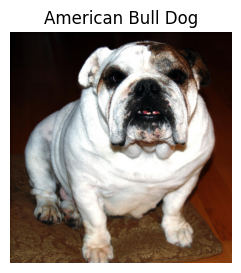

In [40]:
img = load_img('images/2906008778_1baeac7c1b_b.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('American Bull Dog')
plt.show()

In [41]:
x = img_to_array(img)
x2 = x.reshape((1,) + x.shape)

/var/folders/6d/2ljpfvw94vq_1lqbyx7jk68r0000gn/T/ipykernel_36031/327069532.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 3, i)


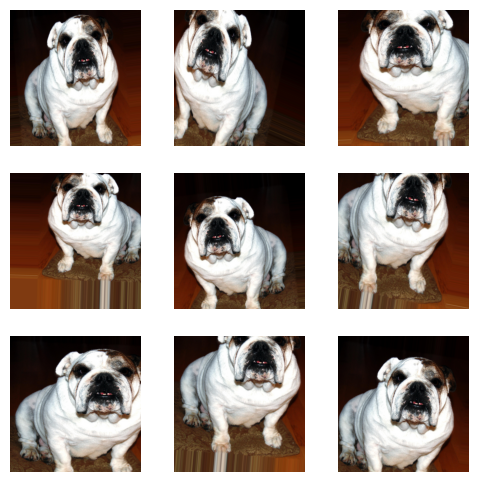

In [42]:
i = 0
fig = plt.figure(figsize = (6,6))
plt.title('Pre-processed')
for batch in datagen.flow(x2, batch_size = 1):
    i += 1
    if i > 9:
        break
    temp = batch.reshape(x.shape)
    plt.subplot(3, 3, i)
    plt.imshow(temp.astype('uint8'))
    plt.axis('off')
plt.show()

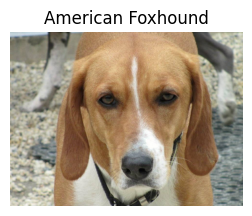

In [43]:
img = load_img('images/8666079478_f15a4bf761_b.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('American Foxhound')
plt.show()

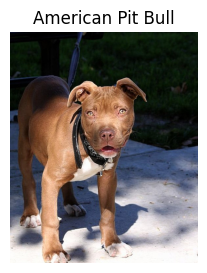

In [44]:
img = load_img('images/3253955567_0a760d07f4.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('American Pit Bull')
plt.show()

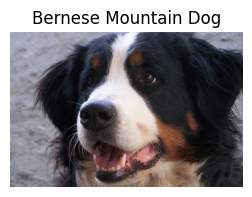

In [45]:
img = load_img('images/515115458_3a2d8e63b0_b.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('Bernese Mountain Dog')
plt.show()

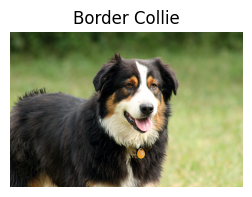

In [46]:
img = load_img('images/367223817_8b489117ba.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('Border Collie')
plt.show()

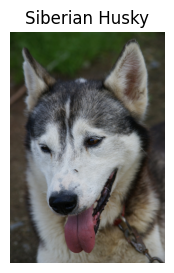

In [47]:
img = load_img('images/1359977110_457925e5f6_b.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('Siberian Husky')
plt.show()

In [48]:
# default settings
img_width, img_height = 224, 224

train_dir = 'data/dogs/train'
validate_dir = 'data/dogs/validate'
nb_epochs = 20
batch_size = 64
nb_classes = len(glob.glob(train_dir + '/*'))

In [49]:
# get number of images in training directory
nb_train_samples = 0
for r, dirs, files in os.walk(train_dir):
    for dr in dirs:
        nb_train_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(nb_train_samples)

386


In [50]:
# get number of images in validation directory
nb_validate_samples = 0
for r, dirs, files in os.walk(validate_dir):
    for dr in dirs:
        nb_validate_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(nb_validate_samples)

110


In [51]:
# data pre-processing for training
train_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [52]:
# data pre-processing for validation
validate_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [53]:
# generate and store training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 386 images belonging to 6 classes.


In [54]:
# generate and store validation data
validate_generator = validate_datagen.flow_from_directory(
    validate_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 110 images belonging to 6 classes.


In [55]:
# set up transfer learning on pre-trained ImageNet VGG16 model - remove fully connected layer and replace
# with softmax for classifying 10 classes
vgg16_model = VGG16(weights = 'imagenet', include_top = False)
x = vgg16_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(nb_classes, activation = 'softmax')(x)
model = Model(inputs = vgg16_model.input, outputs = predictions)

In [56]:
# freeze all layers of the pre-trained model
for layer in vgg16_model.layers:
    layer.trainable = False

In [57]:
# compile the new model using a RMSProp optimizer
model.compile(optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

In [58]:
# fit the model, log the results and the training time
now = datetime.datetime.now
t = now()
transfer_learning_history = model.fit_generator(
    train_generator,
    epochs = nb_epochs,
#     samples_per_epoch = nb_train_samples,
    validation_data = validate_generator
#     nb_val_samples = nb_validate_samples,
#     class_weight='auto')
)
print('Training time: %s' % (now() - t))

/var/folders/6d/2ljpfvw94vq_1lqbyx7jk68r0000gn/T/ipykernel_36031/1653497777.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  transfer_learning_history = model.fit_generator(


Epoch 1/20


2022-10-18 02:31:00.175762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 2.3548 - accuracy: 0.1813

2022-10-18 02:31:12.137324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 17s 2s/step - loss: 2.3548 - accuracy: 0.1813 - val_loss: 1.7523 - val_accuracy: 0.2000
Epoch 2/20
7/7 [==============================] - 11s 1s/step - loss: 1.7521 - accuracy: 0.2694 - val_loss: 1.6871 - val_accuracy: 0.2364
Epoch 3/20
7/7 [==============================] - 10s 1s/step - loss: 1.8027 - accuracy: 0.2798 - val_loss: 1.6521 - val_accuracy: 0.3727
Epoch 4/20
7/7 [==============================] - 10s 1s/step - loss: 1.7032 - accuracy: 0.3446 - val_loss: 1.5904 - val_accuracy: 0.3273
Epoch 5/20
7/7 [==============================] - 10s 1s/step - loss: 1.6392 - accuracy: 0.3342 - val_loss: 2.1289 - val_accuracy: 0.1909
Epoch 6/20
7/7 [==============================] - 10s 1s/step - loss: 1.7763 - accuracy: 0.3472 - val_loss: 1.5361 - val_accuracy: 0.4091
Epoch 7/20
7/7 [==============================] - 11s 1s/step - loss: 1.5833 - accuracy: 0.4067 - val_loss: 1.5340 - val_accuracy: 0.3909
Epoch 8/20
7/7 [=============================

In [59]:
# evaluate the performance the new model and report the results
score = model.evaluate_generator(validate_generator, nb_validate_samples/batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

/var/folders/6d/2ljpfvw94vq_1lqbyx7jk68r0000gn/T/ipykernel_36031/2432328286.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(validate_generator, nb_validate_samples/batch_size)


Test Score: 1.914138674736023
Test Accuracy: 0.27272728085517883


In [60]:
# save transfer learning model for offline prediction purposes
model.save('dogs_vgg16_model_tl.h5')

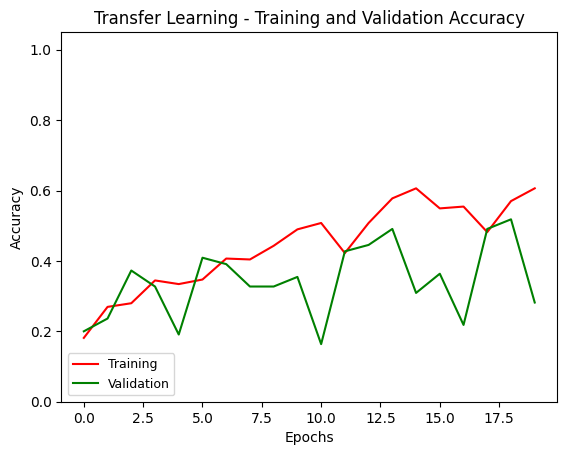

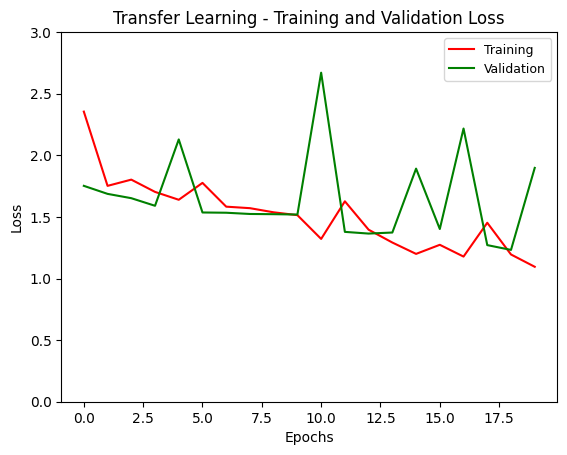

In [103]:
xfer_acc = transfer_learning_history.history['accuracy']
val_acc = transfer_learning_history.history['val_accuracy']
xfer_loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']
epochs = range(len(xfer_acc))

x = np.array(epochs)
y = np.array(xfer_acc)
x_smooth = np.linspace(x.min(), x.max(), 500)
# y_smooth = make_interp_spline(x, y, x_smooth)
plt.plot(x, y, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_acc)
# x1_smooth = np.linspace(x1.min(), x1.max(), 500)
# y1_smooth = make_interp_spline(x1, y1, x1_smooth)

plt.plot(x1, y1, 'g-', label = 'Validation')
plt.title('Transfer Learning - Training and Validation Accuracy')
plt.legend(loc = 'lower left', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1.05)

plt.figure()
x = np.array(epochs)
y = np.array(xfer_loss)
# x_smooth = np.linspace(x.min(), x.max(), 500)
# y_smooth = make_interp_spline(x, y, x_smooth)
plt.plot(x, y, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_loss)
# x1_smooth = np.linspace(x1.min(), x1.max(), 500)
# y1_smooth = make_interp_spline(x1, y1, x1_smooth)

plt.plot(x1, y1, 'g-', label = 'Validation')
plt.title('Transfer Learning - Training and Validation Loss')
plt.legend(loc = 'upper right', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 3)
plt.show()

In [66]:
validate_generator.total_batches_seen

44

In [74]:
num_images = len(glob.glob("data/dogs/dogs_test/*.jpg"))

In [76]:
predict_files = glob.glob("data/dogs/dogs_test/*.jpg")

In [77]:
im = cv2.imread(predict_files[0])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (256, 256)).astype(np.float32)
im = np.expand_dims(im, axis = 0)/255

In [78]:
predictor, image_id = [], []
for i in predict_files:
    im = cv2.imread(i)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    outcome = [np.argmax(model.predict(im))]
    predictor.extend(list(outcome))
    image_id.extend([i.rsplit("\\")[-1]])

2022-10-18 02:40:29.997509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 11ms/step


In [79]:
final = pd.DataFrame()
final["id"] = image_id
final["Dog"] = predictor
final.head(num_images)

,id,Dog
0,data/dogs/dogs_test/american_bull_dog_10453547...,2
1,data/dogs/dogs_test/border_collie_5436726107_0...,3
2,data/dogs/dogs_test/siberian_husky_5054137283_...,2
3,data/dogs/dogs_test/american_foxhound_14768856...,2
4,data/dogs/dogs_test/bernese_mountain_dog_16184...,2
5,data/dogs/dogs_test/american_pit_bull_27048365...,2
6,data/dogs/dogs_test/american_pit_bull_24000237...,2
7,data/dogs/dogs_test/american_foxhound_16969245...,2
8,data/dogs/dogs_test/american_bull_dog_42927468...,2
9,data/dogs/dogs_test/siberian_husky_8460153366_...,2


In [80]:
classes = train_generator.class_indices
classes = {value : key for key, value in classes.items()}

In [81]:
final["Dog"] = final["Dog"].apply(lambda x: classes[x])
final.head(num_images)

,id,Dog
0,data/dogs/dogs_test/american_bull_dog_10453547...,american_pit_bull
1,data/dogs/dogs_test/border_collie_5436726107_0...,bernese_mountain_dog
2,data/dogs/dogs_test/siberian_husky_5054137283_...,american_pit_bull
3,data/dogs/dogs_test/american_foxhound_14768856...,american_pit_bull
4,data/dogs/dogs_test/bernese_mountain_dog_16184...,american_pit_bull
5,data/dogs/dogs_test/american_pit_bull_27048365...,american_pit_bull
6,data/dogs/dogs_test/american_pit_bull_24000237...,american_pit_bull
7,data/dogs/dogs_test/american_foxhound_16969245...,american_pit_bull
8,data/dogs/dogs_test/american_bull_dog_42927468...,american_pit_bull
9,data/dogs/dogs_test/siberian_husky_8460153366_...,american_pit_bull


In [82]:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_4
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 global_average_pooling2d_3
20 dense_6
21 dense_7


In [83]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [87]:
# Step 1 - Set up fine tuning on pre-trained ImageNet VGG16 model - train all layers
for layer in model.layers:
    layer.trainable = True
    
# Step 2 - Compile the revised model using SGD optimizer with a learing rate of 0.0001 and a momentum of 0.9
model.compile(optimizer = SGD(lr = 0.0001, momentum=0.9), 
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

# Step 3 - Fit the revised model, log the results and the training time
now = datetime.datetime.now
t = now()
fine_tuning_history = model.fit_generator(
    train_generator,
    epochs = nb_epochs,
#     samples_per_epoch = nb_train_samples,
    validation_data = validate_generator
#     nb_val_samples = nb_validate_samples,
#     class_weight='auto')
)
print('Training time: %s' % (now() - t))

/var/folders/6d/2ljpfvw94vq_1lqbyx7jk68r0000gn/T/ipykernel_36031/708344884.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fine_tuning_history = model.fit_generator(


Epoch 1/20


2022-10-18 02:41:58.280955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 1.4344 - accuracy: 0.4119

2022-10-18 02:42:27.902588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 33s 4s/step - loss: 1.4344 - accuracy: 0.4119 - val_loss: 1.3763 - val_accuracy: 0.4455
Epoch 2/20
7/7 [==============================] - 32s 4s/step - loss: 1.0528 - accuracy: 0.5699 - val_loss: 1.1757 - val_accuracy: 0.4727
Epoch 3/20
7/7 [==============================] - 29s 5s/step - loss: 0.8832 - accuracy: 0.6710 - val_loss: 1.0261 - val_accuracy: 0.6000
Epoch 4/20
7/7 [==============================] - 30s 4s/step - loss: 0.7463 - accuracy: 0.7332 - val_loss: 1.0189 - val_accuracy: 0.6000
Epoch 5/20
7/7 [==============================] - 30s 4s/step - loss: 0.7098 - accuracy: 0.7150 - val_loss: 0.8995 - val_accuracy: 0.6727
Epoch 6/20
7/7 [==============================] - 30s 4s/step - loss: 0.6623 - accuracy: 0.7539 - val_loss: 0.9293 - val_accuracy: 0.5909
Epoch 7/20
7/7 [==============================] - 30s 4s/step - loss: 0.6631 - accuracy: 0.7642 - val_loss: 0.9317 - val_accuracy: 0.6455
Epoch 8/20
7/7 [=============================

In [88]:
# evaluate the performance the new model and report the results
score = model.evaluate_generator(validate_generator, nb_validate_samples/batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

/var/folders/6d/2ljpfvw94vq_1lqbyx7jk68r0000gn/T/ipykernel_36031/2432328286.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(validate_generator, nb_validate_samples/batch_size)


Test Score: 0.756546139717102
Test Accuracy: 0.6909091472625732


In [89]:
# save fine-tuning model for offline prediction purposes
model.save('dogs_vgg16_model_ft.h5')

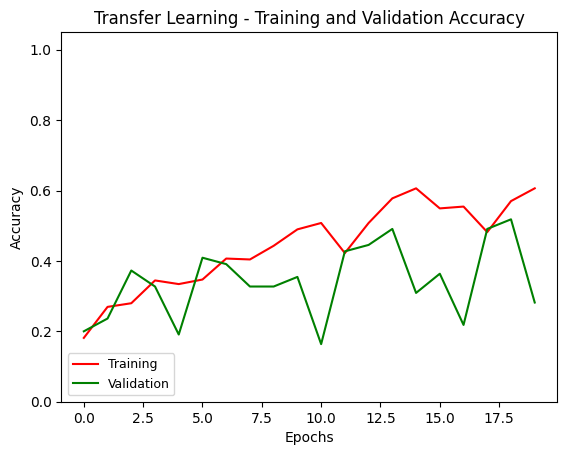

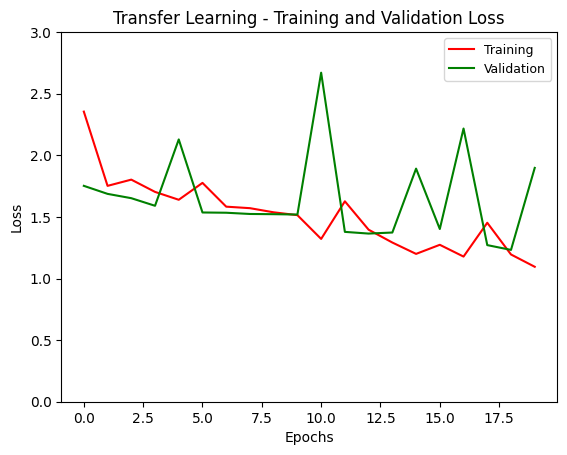

In [104]:
xfer_acc = transfer_learning_history.history['accuracy']
val_acc = transfer_learning_history.history['val_accuracy']
xfer_loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']
epochs = range(len(xfer_acc))

x = np.array(epochs)
y = np.array(xfer_acc)
x_smooth = np.linspace(x.min(), x.max(), 500)
# y_smooth = make_interp_spline(x, y, x_smooth)
plt.plot(x, y, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_acc)
# x1_smooth = np.linspace(x1.min(), x1.max(), 500)
# y1_smooth = make_interp_spline(x1, y1, x1_smooth)

plt.plot(x1, y1, 'g-', label = 'Validation')
plt.title('Transfer Learning - Training and Validation Accuracy')
plt.legend(loc = 'lower left', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1.05)

plt.figure()
x = np.array(epochs)
y = np.array(xfer_loss)
# x_smooth = np.linspace(x.min(), x.max(), 500)
# y_smooth = make_interp_spline(x, y, x_smooth)
plt.plot(x, y, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_loss)
# x1_smooth = np.linspace(x1.min(), x1.max(), 500)
# y1_smooth = make_interp_spline(x1, y1, x1_smooth)

plt.plot(x1, y1, 'g-', label = 'Validation')
plt.title('Transfer Learning - Training and Validation Loss')
plt.legend(loc = 'upper right', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 3)
plt.show()

In [91]:
validate_generator.total_batches_seen

88

In [93]:
# predict unseen images
predict_files = glob.glob("data/dogs/dogs_test/*.jpg")

In [94]:
im = cv2.imread(predict_files[0])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (256, 256)).astype(np.float32)
im = np.expand_dims(im, axis = 0)/255

In [95]:
predictor, image_id = [], []
for i in predict_files:
    im = cv2.imread(i)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    outcome = [np.argmax(model.predict(im))]
    predictor.extend(list(outcome))
    image_id.extend([i.rsplit("\\")[-1]])

1/1 [==============================] - 0s 13ms/step


2022-10-18 02:55:09.048704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 11ms/step


In [96]:
final = pd.DataFrame()
final["id"] = image_id
final["Dog"] = predictor 
final.head(num_images)

,id,Dog
0,data/dogs/dogs_test/american_bull_dog_10453547...,0
1,data/dogs/dogs_test/border_collie_5436726107_0...,3
2,data/dogs/dogs_test/siberian_husky_5054137283_...,4
3,data/dogs/dogs_test/american_foxhound_14768856...,1
4,data/dogs/dogs_test/bernese_mountain_dog_16184...,3
5,data/dogs/dogs_test/american_pit_bull_27048365...,2
6,data/dogs/dogs_test/american_pit_bull_24000237...,2
7,data/dogs/dogs_test/american_foxhound_16969245...,1
8,data/dogs/dogs_test/american_bull_dog_42927468...,2
9,data/dogs/dogs_test/siberian_husky_8460153366_...,5


In [97]:
classes = train_generator.class_indices
classes = {value : key for key, value in classes.items()}

In [98]:
final["Dog"] = final["Dog"].apply(lambda x: classes[x])
final.head(num_images)

,id,Dog
0,data/dogs/dogs_test/american_bull_dog_10453547...,american_bull_dog
1,data/dogs/dogs_test/border_collie_5436726107_0...,bernese_mountain_dog
2,data/dogs/dogs_test/siberian_husky_5054137283_...,border_collie
3,data/dogs/dogs_test/american_foxhound_14768856...,american_foxhound
4,data/dogs/dogs_test/bernese_mountain_dog_16184...,bernese_mountain_dog
5,data/dogs/dogs_test/american_pit_bull_27048365...,american_pit_bull
6,data/dogs/dogs_test/american_pit_bull_24000237...,american_pit_bull
7,data/dogs/dogs_test/american_foxhound_16969245...,american_foxhound
8,data/dogs/dogs_test/american_bull_dog_42927468...,american_pit_bull
9,data/dogs/dogs_test/siberian_husky_8460153366_...,siberian_husky
